In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
import time
import math
import re
from konlpy.tag import Okt


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

okt = Okt()

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"

warnings.filterwarnings('ignore')

In [14]:
#단어 사전 생성
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
class WordVocab():
    def __init__(self):
        SOS_TOKEN = 0
        EOS_TOKEN = 1
        UNKNOWN_TOKEN = 2
        
        self.unknown_token = UNKNOWN_TOKEN
        
        # 각 토큰 별 word count
        self.word2count = {}
        
        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>', 
            UNKNOWN_TOKEN: '<UKN>',
        }
        
        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token
    
    def index_to_word(self, idx):
        return self.index2word[idx]

In [45]:
wordvocab = WordVocab()

In [16]:
#전처리 프로세스를 클레스화 - 데이터 로드, 전처리, 사전 생성, 시퀀스 변환
class QADataset():
    def __init__(self, csv_path, min_length=1, max_length=647):
        data_dir = 'data'
        
        # TOKEN 정의
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰
        
        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정
        
        # CSV 데이터 로드
        df = pd.read_csv(csv_path)
        
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for _, row in df.iterrows():
            src = row['value']
            tgt = row['label']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)            
        
        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab

    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(sentence)
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences
    
    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)

    
    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        
        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        
        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)
    
    def __len__(self):
        return len(self.srcs)

In [17]:
MAX_LENGTH = 647

dataset = QADataset('./input_df.csv', min_length=1, max_length=MAX_LENGTH)

In [18]:
x, y = dataset[3]

# 시퀀스를 문장으로 변환
print(dataset.sequences_to_texts(x))
print(dataset.sequences_to_texts(y))

보통 요즘 현대인 들 이 많이 키우는 반려동물 은 개 고양이 위주 로 많이 키우는데 그 외 에도 요즘 에 이 이색 적 이 게 침팬지 햄스터 혹은 작은 미니 피그 같은 동물 도 많이 키우고 있 있다고 들었습니다 . <EOS>
저 도 기회 가 된다면 나중 에는 고슴도치 같은 걸 키워 보고 싶기도 하고 제 주위 에 뱀 을 뱀 이나 도마뱀 같은 것 을 키우는 사람 도 많고 현재 는 많은 많이 다양해진 반려동물 을 볼 수 있다고 생각 을 하고 있습니다 . <EOS>


Encoder

In [106]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=True, 
                          batch_first=True,
                          dropout=0.2,
                         )
    def init_weights(self):
        initrange = 1
        self.gru.weight.data.uniform_ = (-initrange, initrange)
        
    def forward(self, x, hidden):
        # (sequence_length, 1)
        x = self.embedding(x).view(1, 1, -1)
        # x: (1, 1, embedding_dim)
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        output, hidden = self.gru(x, hidden)
        # output: (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return output, hidden
    
    def init_hidden(self, device):
        # hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32)) 로 초기화
        return torch.zeros(10, 1, self.hidden_size, device=device)

In [107]:
NUM_VOCABS = dataset.wordvocab.n_words
print(f'number of vocabs: {NUM_VOCABS}')

number of vocabs: 89168


Decoder

In [210]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.2, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim , max_length)
        self.attn_combine = nn.Linear(2*hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size,
                          hidden_size,
                          num_layers=5,
                          bidirectional=True,
                          batch_first=True,
                          dropout=dropout_p)
        self.out = nn.Linear(2*hidden_size, num_vocabs)

    def forward(self, x, hidden, encoder_outputs):
        # x: (1, 1) 1개의 토큰
        embedded = self.embedding(x).view(1, 1, -1)
        # embedded: (1, 1, 1)
        embedded = self.dropout(embedded)

        
        # embedded[0]: (1, embedding_dim)
        # hidden[0]: (1, hidden_size)
        attn_in = torch.cat((embedded[0], hidden[0]), 1)
        # attn_in: (1, embedding_dim + hidden_size)
                            
        attn = self.attn(attn_in)
        # attn: (1, max_length)
                         
        attn_weights = F.softmax(attn)
        # attn_weights: (1, max_length)
        
        # (1, 1, max_length), (1, max_length, hidden_size)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: (1, 1, hidden_size)

        # embedded[0]: (1, embedding_dim)
        # attn_applied[0]: (1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: (1, embedding_dim + hidden_size)
        
        output = self.attn_combine(output)
        # output: (1, hidden_size)
        output = output.unsqueeze(0)
        # output: (1, 1, hidden_size)

        output = F.relu(output)
        # output: (1, 1, hidden_size)
        
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        output, hidden = self.gru(output, hidden)
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        
        # output[0]: (1, hidden_size)
        output = self.out(output[0])
        # output: (1, number of vocabs)
        
        # output[0]: (number of vocabs)
        # hidden: (1, 1, hidden_size)
        # attn_weights: (1, max_length)
        return output[0], hidden, attn_weights

    def initHidden(self, device):
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return torch.zeros(2*5, 32, self.hidden_size, device=device)

Training

In [185]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [186]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()
    
# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [187]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    
    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size*2, device=device)
#     print(encoder_outputs.shape) ## (647,512)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
#         print(encoder_output.shape) ## (1,1,2*512)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden

    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di])

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [188]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate, betas=(0.9,0.98))
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, betas=(0.9,0.98))
    
    encoder_scheduler = optim.lr_scheduler.StepLR(optimizer=encoder_optimizer,
                                            step_size=10.0,
                                            gamma=0.95,
                                            verbose=False)
    decoder_scheduler = optim.lr_scheduler.StepLR(optimizer=decoder_optimizer,
                                                 step_size=10.0,
                                                 gamma=0.95,
                                                 verbose=False)
    
    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]
    
    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]        
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion, device)
        encoder_scheduler.step()
        decoder_scheduler.step()
        
        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력, 모델 저장
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                }, "./model/Text2Text-se2se.pth")

            
        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        

    showPlot(plot_losses)

In [230]:
# Hyper-Parameter 정의
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDING_DIM = 700
DROPOUT_P = 0.3
NUM_LAYERS = 5

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=NUM_LAYERS)

# Attention 이 적용된 Decoder 정의
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=MAX_LENGTH)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

3m 33s (remaining: 706m 48s) iter: 500 (0.5%), loss: 6.0823
6m 15s (remaining: 619m 13s) iter: 1000 (1.0%), loss: 5.2131
9m 9s (remaining: 601m 49s) iter: 1500 (1.5%), loss: 5.4477
11m 45s (remaining: 575m 49s) iter: 2000 (2.0%), loss: 5.0303
14m 35s (remaining: 569m 10s) iter: 2500 (2.5%), loss: 5.3420
17m 18s (remaining: 559m 41s) iter: 3000 (3.0%), loss: 5.1322
20m 5s (remaining: 553m 56s) iter: 3500 (3.5%), loss: 5.1115
22m 57s (remaining: 550m 52s) iter: 4000 (4.0%), loss: 5.1441
25m 47s (remaining: 547m 18s) iter: 4500 (4.5%), loss: 4.9302
28m 23s (remaining: 539m 34s) iter: 5000 (5.0%), loss: 5.2282
31m 11s (remaining: 535m 58s) iter: 5500 (5.5%), loss: 5.1212
33m 41s (remaining: 527m 52s) iter: 6000 (6.0%), loss: 5.1581
36m 24s (remaining: 523m 36s) iter: 6500 (6.5%), loss: 5.1350
39m 12s (remaining: 520m 55s) iter: 7000 (7.0%), loss: 5.3365
42m 12s (remaining: 520m 33s) iter: 7500 (7.5%), loss: 5.2533
45m 1s (remaining: 517m 43s) iter: 8000 (8.0%), loss: 5.0868
47m 34s (remain

359m 14s (remaining: 197m 43s) iter: 64500 (64.5%), loss: 5.0750
362m 7s (remaining: 194m 59s) iter: 65000 (65.0%), loss: 5.0202
364m 57s (remaining: 192m 13s) iter: 65500 (65.5%), loss: 5.2345
367m 49s (remaining: 189m 28s) iter: 66000 (66.0%), loss: 5.1642
370m 41s (remaining: 186m 44s) iter: 66500 (66.5%), loss: 5.1943
373m 17s (remaining: 183m 51s) iter: 67000 (67.0%), loss: 5.1170
376m 7s (remaining: 181m 5s) iter: 67500 (67.5%), loss: 5.1313
378m 58s (remaining: 178m 20s) iter: 68000 (68.0%), loss: 5.0520
381m 54s (remaining: 175m 37s) iter: 68500 (68.5%), loss: 5.0796
384m 48s (remaining: 172m 52s) iter: 69000 (69.0%), loss: 5.0211
387m 41s (remaining: 170m 8s) iter: 69500 (69.5%), loss: 4.9770
390m 33s (remaining: 167m 23s) iter: 70000 (70.0%), loss: 5.1828
393m 27s (remaining: 164m 38s) iter: 70500 (70.5%), loss: 5.2066
396m 16s (remaining: 161m 51s) iter: 71000 (71.0%), loss: 5.0810
398m 58s (remaining: 159m 1s) iter: 71500 (71.5%), loss: 5.0716
401m 59s (remaining: 156m 19s)

<Figure size 640x480 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

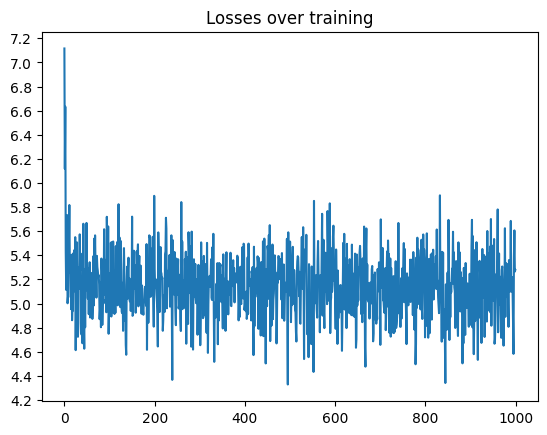

In [232]:
train_iterations(encoder, decoder, 100000, dataset, device, print_every=500)

Evaluation

In [75]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)
        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)

        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data

            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)

            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    
def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
        print('<', output_sentence)
        print('')

In [76]:
# 랜덤 샘플링 된 데이터 evaluate
evaluate_randomly(encoder, decoder, dataset, device)

> 원하지 않은 사람 은 퇴근 후 에 집 에 가서 휴식 을 취할 수 있도록 좀 보장 을 해 주었으면 하는 개인 적 인 바람 이 있습니다 . <EOS>
= 회식 에 대한 생각 이 있으신 가요 ? <EOS>
< 그래서 가 에 가 에 이 이 이 이 . <EOS>

> 저 는 제일 중요하다고 생각 하는 부분 이 갑 을 관계 가 없는 그런 관계 가 제일 중요하다고 생각 합니다 . <EOS>
= 어떤 연애 든 주도 권 을 잡는 사람 이 있으면 그 사람 의 의견 을 따를 수 밖에 없고 나중 에는 분명 한쪽 에서 참아 왔던 작은 소소한 부분 들 까지 큰 싸움 의 불씨 를 만들 수 있기 때문 에 저 는 갑 을 관계 가 없어야 된다는 걸 제일 중요하다고 생각 하고요 . <EOS>
< 그래서 가 는 가 에 이 이 이 . <EOS>

> 어 저 는 제 가 예전 에 이제 취업 준비 할 때 한 달 정도 영국 이 아 유럽 에 있었던 적 있어요 . <EOS>
= 여행 으로 근데 그때 한 달이 너무 좋았어서 스페인 을 간다 치면 은 최소 2 주 에서 길게는 한 달 정도 를 생각 했어서 뭐 한 달 살기 까지라고 하긴 조금 오번 거 같고 그냥 조금 스페인 의 군데 군데 도시 도시 를 조금 많이 다니면서 여행 겸 살기 정도 를 생각 을 했었는데 혹시 뭐 어 그 이전 에 장기로 여행 을 가 보신 적은 있으세요 ? <EOS>
< 그래서 가 는 가 에 이 이 이 . <EOS>

> 네 선물 같은 경우 에 감동 이라는 그러니까 감동 을 받은 선물 이 있고 그렇지 않은 선물 이 있잖아요 . <EOS>
= 물론 주는 사람 의 마음 을 어 느낄 수 있는 선물 이 되게 감동 적 이기는 한데 굳이 내 가 이 게 필요하나 필요하지 않는데 혹은 내 가 별로 이 거 가지 고 싶지 않다고 했고 있다고 생각 하는데 라는 선물 을 받게 되면 참 받는 사람 입장 에서도 난감하고 어 고마움 을 바로바로 표시 해야 할 때 어떻게 표시 를 해야 되는지 고민 이 되는 부분 이 있는 거 같아요 . <EOS>
< 그래서 가 는 가 에

attention 가중치 시각화

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

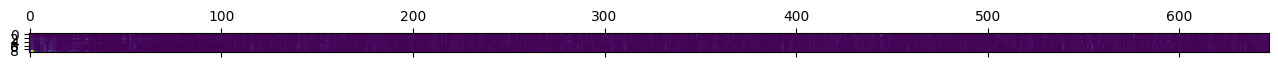

In [73]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, dataset[2][0].to(device), dataset, device)
plt.matshow(attentions.numpy())
plt.show()

In [74]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

In [71]:
dataset[2][0]

In [72]:
evaluate_and_show_attention(encoder, decoder, dataset[2][1], dataset, device)

In [78]:
import matplotlib.font_manager as fm

fonts = fm.findSystemFonts()
font_names = [fm.FontProperties(fname=font).get_name() for font in fonts]

print(font_names)

RuntimeError: In FT2Font: Can not load face (unknown file format; error code 0x2)